In [1]:
from tensorboard import version; print(version.VERSION)

2.9.1


In [78]:
import torch
import os
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import dill
import pickle

from pytorch_forecasting import TimeSeriesDataSet, Baseline
from pytorch_forecasting.metrics import MAE, MAPE, SMAPE, RMSE, QuantileLoss

# For plotting
from sklearn.neighbors import KernelDensity
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
# from matplotlib import colormaps
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
torch.cuda.empty_cache()

# Paths, lags and lead, time index (weekly resolution)
BASE_PATH = 'D:/KIMoDIs/global-groundwater-models-main'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')
FIGURES_PATH = os.path.join(BASE_PATH, 'figures')
SHARE_PATH = 'J:/Berlin/B22-FISHy/NUTZER/Kunz.S'
CACHE_PATH = os.path.join(BASE_PATH, 'cache')

LAG = 52  # weeks
LEAD = 12  # weeks

# Roughly 80/10/10
TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2010, 1, 1))
VAL_PERIOD = (pd.Timestamp(2010, 1, 1), pd.Timestamp(2013, 1, 1))
TEST_PERIOD = (pd.Timestamp(2013, 1, 1), pd.Timestamp(2016, 1, 1))

TIME_IDX = pd.date_range(TRAIN_PERIOD[0], TEST_PERIOD[1], freq='W-SUN', inclusive='neither', name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

In [2]:
# Change the model type here
MODEL_TYPE = 'full'
VERSION = '10_Epochs'

In [3]:
train_df = pq.read_table(os.path.join(SHARE_PATH, 'train_df.parquet'))
train_df = train_df.to_pandas()
val_df = pq.read_table(os.path.join(SHARE_PATH, 'val_df.parquet'))
val_df = val_df.to_pandas()
test_df = pq.read_table(os.path.join(SHARE_PATH, 'test_df.parquet'))
test_df = test_df.to_pandas()

test_df_in_sample = test_df[test_df['proj_id'].isin(train_df['proj_id'].unique())]

In [58]:
# TimeSeriesDataSets
train_ds = TimeSeriesDataSet.load(os.path.join(SHARE_PATH, f'train_ds_{MODEL_TYPE}_tft.pt'))

# Batch size needs to be smaller than horizon (probaly)
val_ds = TimeSeriesDataSet.load(os.path.join(SHARE_PATH, f'val_ds_{MODEL_TYPE}_tft.pt'))
val_dataloader = val_ds.to_dataloader(train=False, batch_size=8, num_workers=0)

test_ds_in_sample = TimeSeriesDataSet.from_dataset(train_ds, test_df_in_sample) 
test_dataloader_in_sample = test_ds_in_sample.to_dataloader(train=False, batch_size=2, num_workers=0)

## Calculate baseline predictions (naive forecast)

### Validation set

In [5]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions_val = Baseline().predict(val_dataloader,
                                              mode='prediction',
                                              return_y=True,
                                              return_index=True,
                                              trainer_kwargs=dict(accelerator='cpu', 
                                                                               devices=1))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
baseline_index_val = baseline_predictions_val.index
baseline_predictions_val = baseline_predictions_val.output.numpy()

In [ ]:
def predictions_to_df(index: pd.DataFrame, predictions: np.ndarray, group_ids, date_range, lead):
    
    predictions_df = index
    for i, f in enumerate(predictions):
        predictions_df[i] = f

    predictions_df = predictions_df.melt(id_vars=group_ids + ['time_idx'], value_vars=list(range(lead)), var_name='horizon', value_name='forecast')
    predictions_df['time_idx'] = predictions_df['time_idx'] + predictions_df['horizon']
    predictions_df = predictions_df.merge(date_range, on=['time_idx'], how='left')
    predictions_df['horizon'] += 1
    predictions_df.drop('time_idx', axis=1, inplace=True)
    predictions_df.set_index(group_ids+['time', 'horizon'], inplace=True)
    return predictions_df

baseline_predictions_val = predictions_to_df(baseline_index_val, np.transpose(baseline_predictions_val, (1, 0)), ['proj_id'], TIME_IDX, LEAD)

baseline_predictions_val = baseline_predictions_val.reset_index().merge(val_df[['proj_id', 'time', 'gwl']], on=['proj_id', 'time'], how='left').set_index(['proj_id', 'time', 'horizon'])
baseline_predictions_val.reset_index().to_feather(os.path.join(RESULT_PATH, 
                                               'predictions',
                                               'baseline',
                                               'baseline_predictions_validation.feather'))

In [ ]:
baseline_predictions_val = pd.read_feather(os.path.join(RESULT_PATH, 
                                               'predictions',
                                               'baseline',
                                               'baseline_predictions_validation.feather'))

# RM NAs and duplicates
baseline_predictions_val = baseline_predictions_val[~baseline_predictions_val['forecast'].isnull()]
baseline_predictions_val = baseline_predictions_val[~baseline_predictions_val.duplicated(subset=['proj_id', 'time', 'horizon'])]

### Test set

In [59]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions_test = Baseline().predict(test_dataloader_in_sample,
                                               mode='prediction',
                                               return_y=True,
                                               return_index=True,
                                               trainer_kwargs=dict(accelerator='cpu', 
                                                                   devices=1))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
baseline_index_test = baseline_predictions_test.index
baseline_predictions_test = baseline_predictions_test.output.numpy()

baseline_predictions_test = predictions_to_df(baseline_index_test, np.transpose(baseline_predictions_test, (1, 0)), ['proj_id'], TIME_IDX, LEAD)

baseline_predictions_test = baseline_predictions_test.reset_index().merge(test_df_in_sample[['proj_id', 'time', 'gwl']], on=['proj_id', 'time'], how='left').set_index(['proj_id', 'time', 'horizon'])
baseline_predictions_test.reset_index().to_feather(os.path.join(RESULT_PATH, 
                                                  'predictions',
                                                  'baseline',
                                                  'baseline_predictions_test_in_sample.feather'))

In [62]:
baseline_predictions_test = pd.read_feather(os.path.join(RESULT_PATH, 
                                               'predictions',
                                               'baseline',
                                               'baseline_predictions_test_in_sample.feather'))

# RM NAs and duplicates
baseline_predictions_test = baseline_predictions_test[~baseline_predictions_test['forecast'].isnull()]
baseline_predictions_test = baseline_predictions_test[~baseline_predictions_test.duplicated(subset=['proj_id', 'time', 'horizon'])]

### Evaluate predictions

In [ ]:
# Validation dataset
from utils import get_metrics

baseline_predictions_val.set_index(['proj_id', 'time', 'horizon'], inplace=True)
baseline_metrics_val = get_metrics(baseline_predictions_val, metrics_subset=['RMSE', 'MAE', 'NSE'])
baseline_metrics_val.reset_index(inplace=True)

In [55]:
nse_baseline_val = {'Median_NSE_Baseline': baseline_metrics_val.groupby(['horizon'])['NSE'].median()}
nse_baseline_val = pd.DataFrame(nse_baseline_val)
nse_baseline_val.reset_index(inplace=True)
nse_baseline_val

,horizon,Median_NSE_Baseline
0,1,0.9160
1,2,0.8030
2,3,0.6805
3,4,0.5340
4,5,0.3730
5,6,0.2055
6,7,0.0220
7,8,-0.1660
8,9,-0.3510
9,10,-0.5290


In [63]:
# Test dataset
baseline_predictions_test.set_index(['proj_id', 'time', 'horizon'], inplace=True)
baseline_metrics_test = get_metrics(baseline_predictions_test, metrics_subset=['RMSE', 'MAE', 'NSE'])
baseline_metrics_test.reset_index(inplace=True)

In [69]:
nse_baseline_test = {'Median_NSE_Baseline': baseline_metrics_test.groupby(['horizon'])['NSE'].median()}
nse_baseline_test = pd.DataFrame(nse_baseline_test)
nse_baseline_test.reset_index(inplace=True)
nse_baseline_test

,horizon,Median_NSE_Baseline
0,1,0.917
1,2,0.819
2,3,0.708
3,4,0.581
4,5,0.442
5,6,0.302
6,7,0.162
7,8,0.021
8,9,-0.120
9,10,-0.267


In [75]:
nse_baseline_test.rename(columns={'horizon':'Horizon'}, inplace=True)
nse_baseline_test.to_csv(os.path.join(RESULT_PATH,
                                     'predictions',
                                     'baseline',
                                     'baseline_NSE_test_in_sample.csv'))



In [79]:
nse_baseline_test.to_csv(os.path.join(SHARE_PATH,
                                     'global_mod_paper',
                                     'results',
                                     'baseline',
                                     'baseline_NSE_test_in_sample.csv'))

In [82]:
FONT_SIZE = 18
col_grey ='#bababa'

# plt.style.use('seaborn-v0_8')
sns.set(rc=
    {"font.size": FONT_SIZE,
     "axes.titlesize": FONT_SIZE,
     "axes.labelsize": FONT_SIZE,
     "xtick.labelsize": FONT_SIZE-2,
     "ytick.labelsize": FONT_SIZE-2,
     "legend.fontsize": FONT_SIZE-2,
     "legend.title_fontsize": FONT_SIZE-2,
    }
)
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': FONT_SIZE,
    'axes.labelsize':FONT_SIZE-2,
    'axes.labelweight': 'bold',
    'axes.titleweight':'bold',
    
    'legend.fontsize': FONT_SIZE-2,
    'legend.title_fontsize': FONT_SIZE-2,
    
    'axes.facecolor': 'white',
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'major',
    'grid.linestyle': '--',
    'grid.color': 'gray',
    'grid.linewidth': '0.5',
    
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    
    'savefig.bbox':'tight',
    'savefig.dpi':300
})

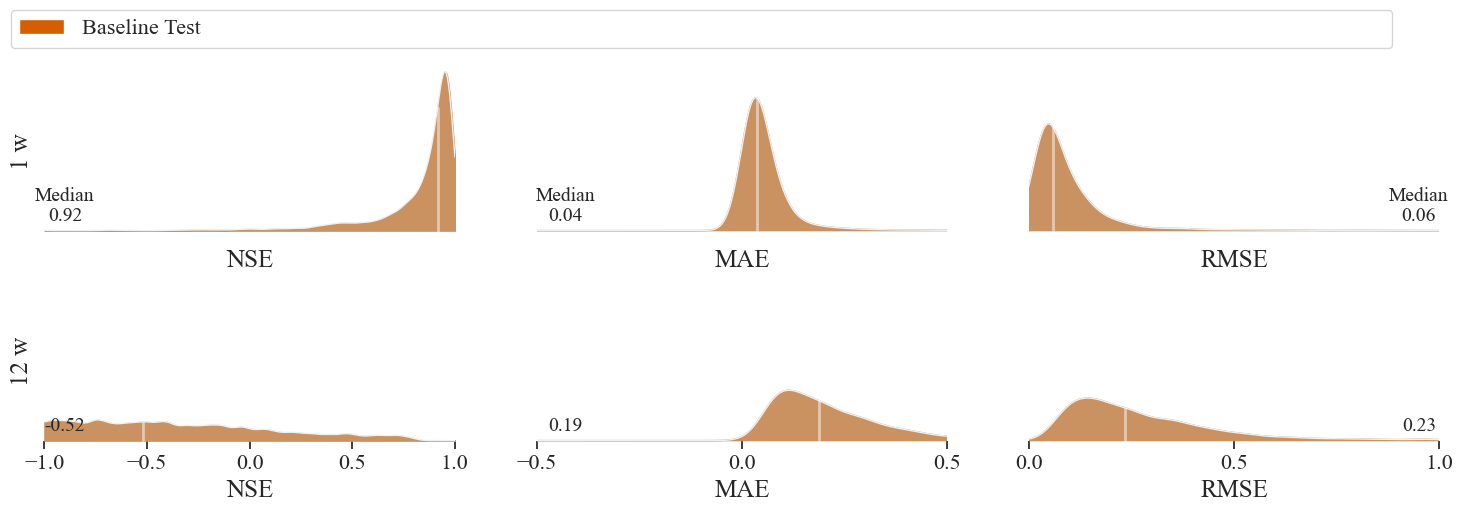

In [93]:
p = palette = sns.color_palette("colorblind")
colors = [p[5], p[5]] # , p[6], p[3], p[1], p[0], p[2], p[4]

horizons = [1, 12]
# models = ['tft', 'nhits']
models = ['tft']

fig_04, ax = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

test_position = [-0.9,-0.43,0.95,3.8]
for j, (metric, _range) in enumerate([('NSE', (-1,1)), ('MAE', (-0.5, 0.5)), ('RMSE', (0., 1))]):
    for i, HORIZON in enumerate(horizons):
        x = baseline_metrics_test[(baseline_metrics_test['horizon'] == HORIZON)][metric].replace([np.inf, -np.inf], np.nan).dropna().values
        median = np.median(x)
        x_d = np.linspace(-1,4, 2000)
        
        kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
        kde.fit(x[:, None])
        logprob = kde.score_samples(x_d[:, None])
        y_d = np.exp(logprob)

        if metric == 'NSE':
            y_d *= 2
        elif metric == 'Interval Score':
            y_d *= 4
        
        if j == 0:
            ax[i, j].set_ylabel(f'{HORIZON} w')
            
        # plotting the distribution
        ax[i, j].plot(x_d, y_d, color="#f0f0f0", lw=1)
        ax[i, j].fill_between(x_d, y_d, alpha=1, color=colors[i])
        
        median_index = np.abs(x_d - median).argmin()
        median_y = y_d[median_index]
        ax[i, j].plot((median,median), (0,median_y), color="white", alpha = 0.5, lw=2)   
        if i == 0:
            ax[i, j].text(test_position[j], 0.4, 'Median\n{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
        else:
            ax[i, j].text(test_position[j], 0.4, '{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
      
        # setting uniform x and y lims
        ax[i, j].set_xlim(_range)
        # ax[i, j].set_ylim(0, 8)

        # make background transparent
        rect = ax[i, j].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and y labels, set x labels
        ax[i, j].set_yticklabels([])
        ax[i, j].grid(False)
        ax[i, j].set_xlabel(metric)
        
        if i == 1:
            ax[i, j].xaxis.set_ticks_position('bottom')
            if j == 1:
                ax[i, j].set_xticks((-0.5,0,0.5))                
            elif j==2:
                ax[i, j].set_xticks((0,0.5,1))
        else:
            ax[i, j].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax[i, j].spines[s].set_visible(False)

# plt.subplots_adjust(hspace=-.75)
ylim = ax[0,0].get_ylim()
legend_elements = [Patch(facecolor=p[3], edgecolor=None, label='Baseline Test')]
fig_04.legend(handles=legend_elements,mode = "expand", bbox_to_anchor=(0.1, 1, 0.78, 0.01))
#fig_04.savefig(os.path.join(FIGURES_PATH, 
#                            'tft',
#                            f'tft_{MODEL_TYPE}',
#                            f'tft_full_4096_{VERSION}',
#                            'metrics_tft.png'), format='png', dpi=300.0)
plt.show()